In [1]:
import matplotlib.pyplot as plt
import os
# set working directory for all future cells
os.chdir("/home/yaminb/Project/Proj23")
# and check with bash command pwd - note the exclamation mark at the beginning
!pwd
# or in python
os.getcwd()



/home/yaminb/Project/Proj23


'/home/yaminb/Project/Proj23'

In [13]:
while getopts d:t:f: flag
do
    case "${flag}" in
        d) directory=${OPTARG};;
        t) tmp=${OPTARG};;
        f) fullname=${OPTARG};;
    esac
done

mkdir ${directory}
mkdir ${directory}/log
mkdir ${directory}/dump
mkdir ${directory}/restart
mkdir ${directory}/colvar
mkdir ${directory}/data
cp /baserun/restart./${tmp}.50000 ${directory}/restart

##########################################################################

cat > "in.partitions" << EOF
    variable p_id world   0 # 1 2 3 4 5
EOF

cat > "in.temp" << EOF
    variable temperature equal \${tmp}
    variable tempDamp equal 0.1 # approx 0.1 ps
EOF

cat > "in.pressure" << EOF
    variable pressure equal 1.
    variable pressureDamp equal 10.0
EOF

cat > "in.seed" << EOF
    variable seed world 74581 # 93734 12832 21934 57383 49172
EOF

cat > "in.box" << EOF
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 \${side} 0 \${side} 0 \${side}
    create_box      1 box
    create_atoms    1 random \${numAtoms} \${seed} box
    mass            1 \${mass}
    change_box      all triclinic
EOF

cat > "in.na" << EOF
    ### Argon Potential Parameters ###
    pair_style  eam/fs
    pair_coeff  * * Na_MendelevM_2014.eam.fs Na
EOF


cat > "in.setup" << EOF
    variable        out_freq equal 500
    variable        out_freq2 equal 25000
    neigh_modify    delay 10 every 1
    include         in.na
    timestep        0.002 # According to Frenkel and Smit is 0.001
    thermo          \${out_freq}
    thermo_style    custom step temp pe ke press density vol enthalpy atoms lx ly lz xy xz yz pxx pyy pzz pxy pxz pyz
    restart         \${out_freq2} \${directory}/restart/restart.\${temperature}
EOF

cat > "in.dump" << EOF
    dump         myDump all atom \${out_freq2} \${directory}/dump/dump\${temperature}.lammpstrj
    dump_modify  myDump append yes
EOF

##########################################################################

cat > "plumed.dat" << EOF
RESTART

LOAD FILE=../PRL-2017-PairEntropy/PairEntropy.cpp

PAIRENTROPY ...
 LABEL=s2
 ATOMS=1-250
 MAXR=0.7
 SIGMA=0.0125
... PAIRENTROPY

ENERGY LABEL=ene

VOLUME LABEL=vol

COMBINE ...
 ARG=ene,vol
 POWERS=1,1
 COEFFICIENTS=1.,0.060221409
 PERIODIC=NO
 LABEL=enthalpy
... COMBINE

COMBINE ...
 ARG=enthalpy
 POWERS=1
 COEFFICIENTS=0.004
 PERIODIC=NO
 LABEL=enthalpyPerAtom
... COMBINE

METAD ...
 LABEL=metad
 ARG=enthalpyPerAtom,s2
 SIGMA=0.2,0.1
 HEIGHT=2.5
 BIASFACTOR=30
 TEMP=350.0
 PACE=500
 GRID_MIN=-110,-8
 GRID_MAX=-90,-1
 GRID_BIN=500,500
 CALC_RCT
... METAD

PRINT STRIDE=500  ARG=* FILE=\${directory}/colvar/COLVAR

EOF
 
##########################################################################
    
cat > "restart.lmp" << EOF
echo both

include in.partitions
log ${directory}/log/log.lammps append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
read_restart ${directory}/restart/restart.\${temperature}.50000
include in.setup

# NVT
variable kenergy equal ke
variable penergy equal pe
variable pres equal press
variable tempera equal temp
variable dense equal density
variable entha equal enthalpy 

fix myat1 all ave/time 100 5 1000 v_kenergy v_penergy v_pres v_tempera v_dense v_entha file /${directory}/data/energy\${temperature}.dat

timer           timeout 23:50:00 every 5000

include         in.dump

fix             1 all plumed plumedfile plumed.dat outfile plumed\${temperature}.out
fix             2 all nph &
                x \${pressure} \${pressure} \${pressureDamp} &
                y \${pressure} \${pressure} \${pressureDamp} &
                z \${pressure} \${pressure} \${pressureDamp} &
                xy 0.0 0.0 \${pressureDamp} &
                yz 0.0 0.0 \${pressureDamp} &
                xz 0.0 0.0 \${pressureDamp} &
                couple xyz
fix             3 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}
fix             4 all momentum 10000 linear 1 1 1 angular

run           10000000 # 20 ns

EOF

/home/yaminb/Project/Proj23


In [8]:
%%bash
cat > "in.partitions" << EOF
    variable p_id world   0 # 1 2 3 4 5
EOF

cat > "in.temp" << EOF
    variable temperature equal \${tmp}
    variable tempDamp equal 0.1 # approx 0.1 ps
EOF

cat > "in.pressure" << EOF
    variable pressure equal 1.
    variable pressureDamp equal 10.0
EOF

cat > "in.seed" << EOF
    variable seed world 74581 # 93734 12832 21934 57383 49172
EOF

cat > "in.box" << EOF
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 \${side} 0 \${side} 0 \${side}
    create_box      1 box
    create_atoms    1 random \${numAtoms} \${seed} box
    mass            1 \${mass}
    change_box      all triclinic
EOF

cat > "in.na" << EOF
    ### Argon Potential Parameters ###
    pair_style  eam/fs
    pair_coeff  * * Na_MendelevM_2014.eam.fs Na
EOF


cat > "in.setup" << EOF
    variable        out_freq equal 500
    variable        out_freq2 equal 25000
    neigh_modify    delay 10 every 1
    include         in.na
    timestep        0.002 # According to Frenkel and Smit is 0.001
    thermo          \${out_freq}
    thermo_style    custom step temp pe ke press density vol enthalpy atoms lx ly lz xy xz yz pxx pyy pzz pxy pxz pyz
    restart         \${out_freq2} restart/metad/restart.\${temperature}
EOF

cat > "in.dump" << EOF
    dump         myDump all atom \${out_freq2} dump/metad/dump\${temperature}.lammpstrj
    dump_modify  myDump append yes
EOF

In [3]:
%%bash
# create PLUMED input file
cat > "plumed.dat" << EOF
RESTART

LOAD FILE=../PRL-2017-PairEntropy/PairEntropy.cpp

PAIRENTROPY ...
 LABEL=s2
 ATOMS=1-250
 MAXR=0.7
 SIGMA=0.0125
... PAIRENTROPY

ENERGY LABEL=ene

VOLUME LABEL=vol

COMBINE ...
 ARG=ene,vol
 POWERS=1,1
 COEFFICIENTS=1.,0.060221409
 PERIODIC=NO
 LABEL=enthalpy
... COMBINE

COMBINE ...
 ARG=enthalpy
 POWERS=1
 COEFFICIENTS=0.004
 PERIODIC=NO
 LABEL=enthalpyPerAtom
... COMBINE

METAD ...
 LABEL=metad
 ARG=enthalpyPerAtom,s2
 SIGMA=0.2,0.1
 HEIGHT=2.5
 BIASFACTOR=30
 TEMP=350.0
 PACE=500
 GRID_MIN=-110,-8
 GRID_MAX=-90,-1
 GRID_BIN=500,500
 CALC_RCT
... METAD

PRINT STRIDE=500  ARG=* FILE=colvars/COLVAR

EOF

In [11]:
%%bash
cat > "restart.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
read_restart restart/metad/restart.\${temperature}.50000
include in.setup

# NVT
variable kenergy equal ke
variable penergy equal pe
variable pres equal press
variable tempera equal temp
variable dense equal density
variable entha equal enthalpy 

fix myat1 all ave/time 100 5 1000 v_kenergy v_penergy v_pres v_tempera v_dense v_entha file data/metad/energy\${temperature}.dat

# timer           timeout 23:50:00 every 5000

include         in.dump

fix             1 all plumed plumedfile plumed.dat outfile plumed\${f}.out
fix             2 all nph &
                x \${pressure} \${pressure} \${pressureDamp} &
                y \${pressure} \${pressure} \${pressureDamp} &
                z \${pressure} \${pressure} \${pressureDamp} &
                xy 0.0 0.0 \${pressureDamp} &
                yz 0.0 0.0 \${pressureDamp} &
                xz 0.0 0.0 \${pressureDamp} &
                couple xyz
fix             3 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}
fix             4 all momentum 10000 linear 1 1 1 angular

run           10000000 # 20 ns

EOF

In [12]:
%%bash
mpirun -np 4 lmp_mpi -v tmp 350 -v f metad -in restart.lmp

LAMMPS (23 Jun 2022 - Update 4)

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 350
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
read_restart restart/metad/restart.${temperature}.50000
read_restart restart/metad/restart.350.50000
Reading restart file ...
  restart file = 23 Jun 2022, LAMMPS = 23 Jun 2022
  restoring atom style full from restart
  triclinic box = (0.076426889 0.076426889 0.076426889) to (21.923573 21.923573 21.923573) with tilt (0 0 0)
  1 by 2 by 2 MPI processor grid
  pair style eam/fs stores no restart info
  250 atoms
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:    0        0        0      

../PRL-2017-PairEntropy/PairEntropy.cpp: In member function ‘virtual void PLMD::colvar::PairEntropy::calculate()’:
../PRL-2017-PairEntropy/PairEntropy.cpp:264:21: warning: comparison of integer expressions of different signedness: ‘int’ and ‘unsigned int’ [-Wsign-compare]
  264 |          if (minBin > (nhist-1)) minBin=nhist-1;
      |              ~~~~~~~^~~~~~~~~~~
../PRL-2017-PairEntropy/PairEntropy.cpp:266:21: warning: comparison of integer expressions of different signedness: ‘int’ and ‘unsigned int’ [-Wsign-compare]
  266 |          if (maxBin > (nhist-1)) maxBin=nhist-1;
      |              ~~~~~~~^~~~~~~~~~~


fix             2 all nph                 x ${pressure} ${pressure} ${pressureDamp}                 y ${pressure} ${pressure} ${pressureDamp}                 z ${pressure} ${pressure} ${pressureDamp}                 xy 0.0 0.0 ${pressureDamp}                 yz 0.0 0.0 ${pressureDamp}                 xz 0.0 0.0 ${pressureDamp}                 couple xyz
fix             2 all nph                 x 1 ${pressure} ${pressureDamp}                 y ${pressure} ${pressure} ${pressureDamp}                 z ${pressure} ${pressure} ${pressureDamp}                 xy 0.0 0.0 ${pressureDamp}                 yz 0.0 0.0 ${pressureDamp}                 xz 0.0 0.0 ${pressureDamp}                 couple xyz
fix             2 all nph                 x 1 1 ${pressureDamp}                 y ${pressure} ${pressure} ${pressureDamp}                 z ${pressure} ${pressure} ${pressureDamp}                 xy 0.0 0.0 ${pressureDamp}                 yz 0.0 0.0 ${pressureDamp}                 xz 0.0 0.0 ${pre

     55000   336.1934      -255.91898      10.820645     -208.43374      0.91331497     10449.683     -246.45778            250   21.862561      21.862561      21.862561      0.56241644     0.012746551   -0.61182494    -411.29792     -258.88119      44.877884     -444.98837     -55.73804       571.92697    
     55500   365.38285     -253.73973      11.760131      671.32651      0.92236567     10347.146     -237.64405            250   21.790817      21.790817      21.790817      0.76021146    -0.023095137   -0.47441272     826.49071      808.46347      379.02535     -370.28891      130.27635      147.30702    
     56000   330.0603      -256.14         10.623247     -63.566194      0.92374303     10331.717     -245.92666            250   21.779981      21.779981      21.779981      0.98307903    -0.066433599   -0.27515134     1034.7076     -543.79167     -681.61448     -29.846676     -321.81505     -333.3636     
     56500   368.69303     -255.74338      11.866671      539.03066      

PLUMED instances was not properly deallocated in your code: 1
PLUMED instances was not properly deallocated in your code: 1
PLUMED instances was not properly deallocated in your code: 1
PLUMED instances was not properly deallocated in your code: 1


Process is interrupted.


/tmp/ipykernel_3424/1966802679.py:6: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("colvars/COLVAR")


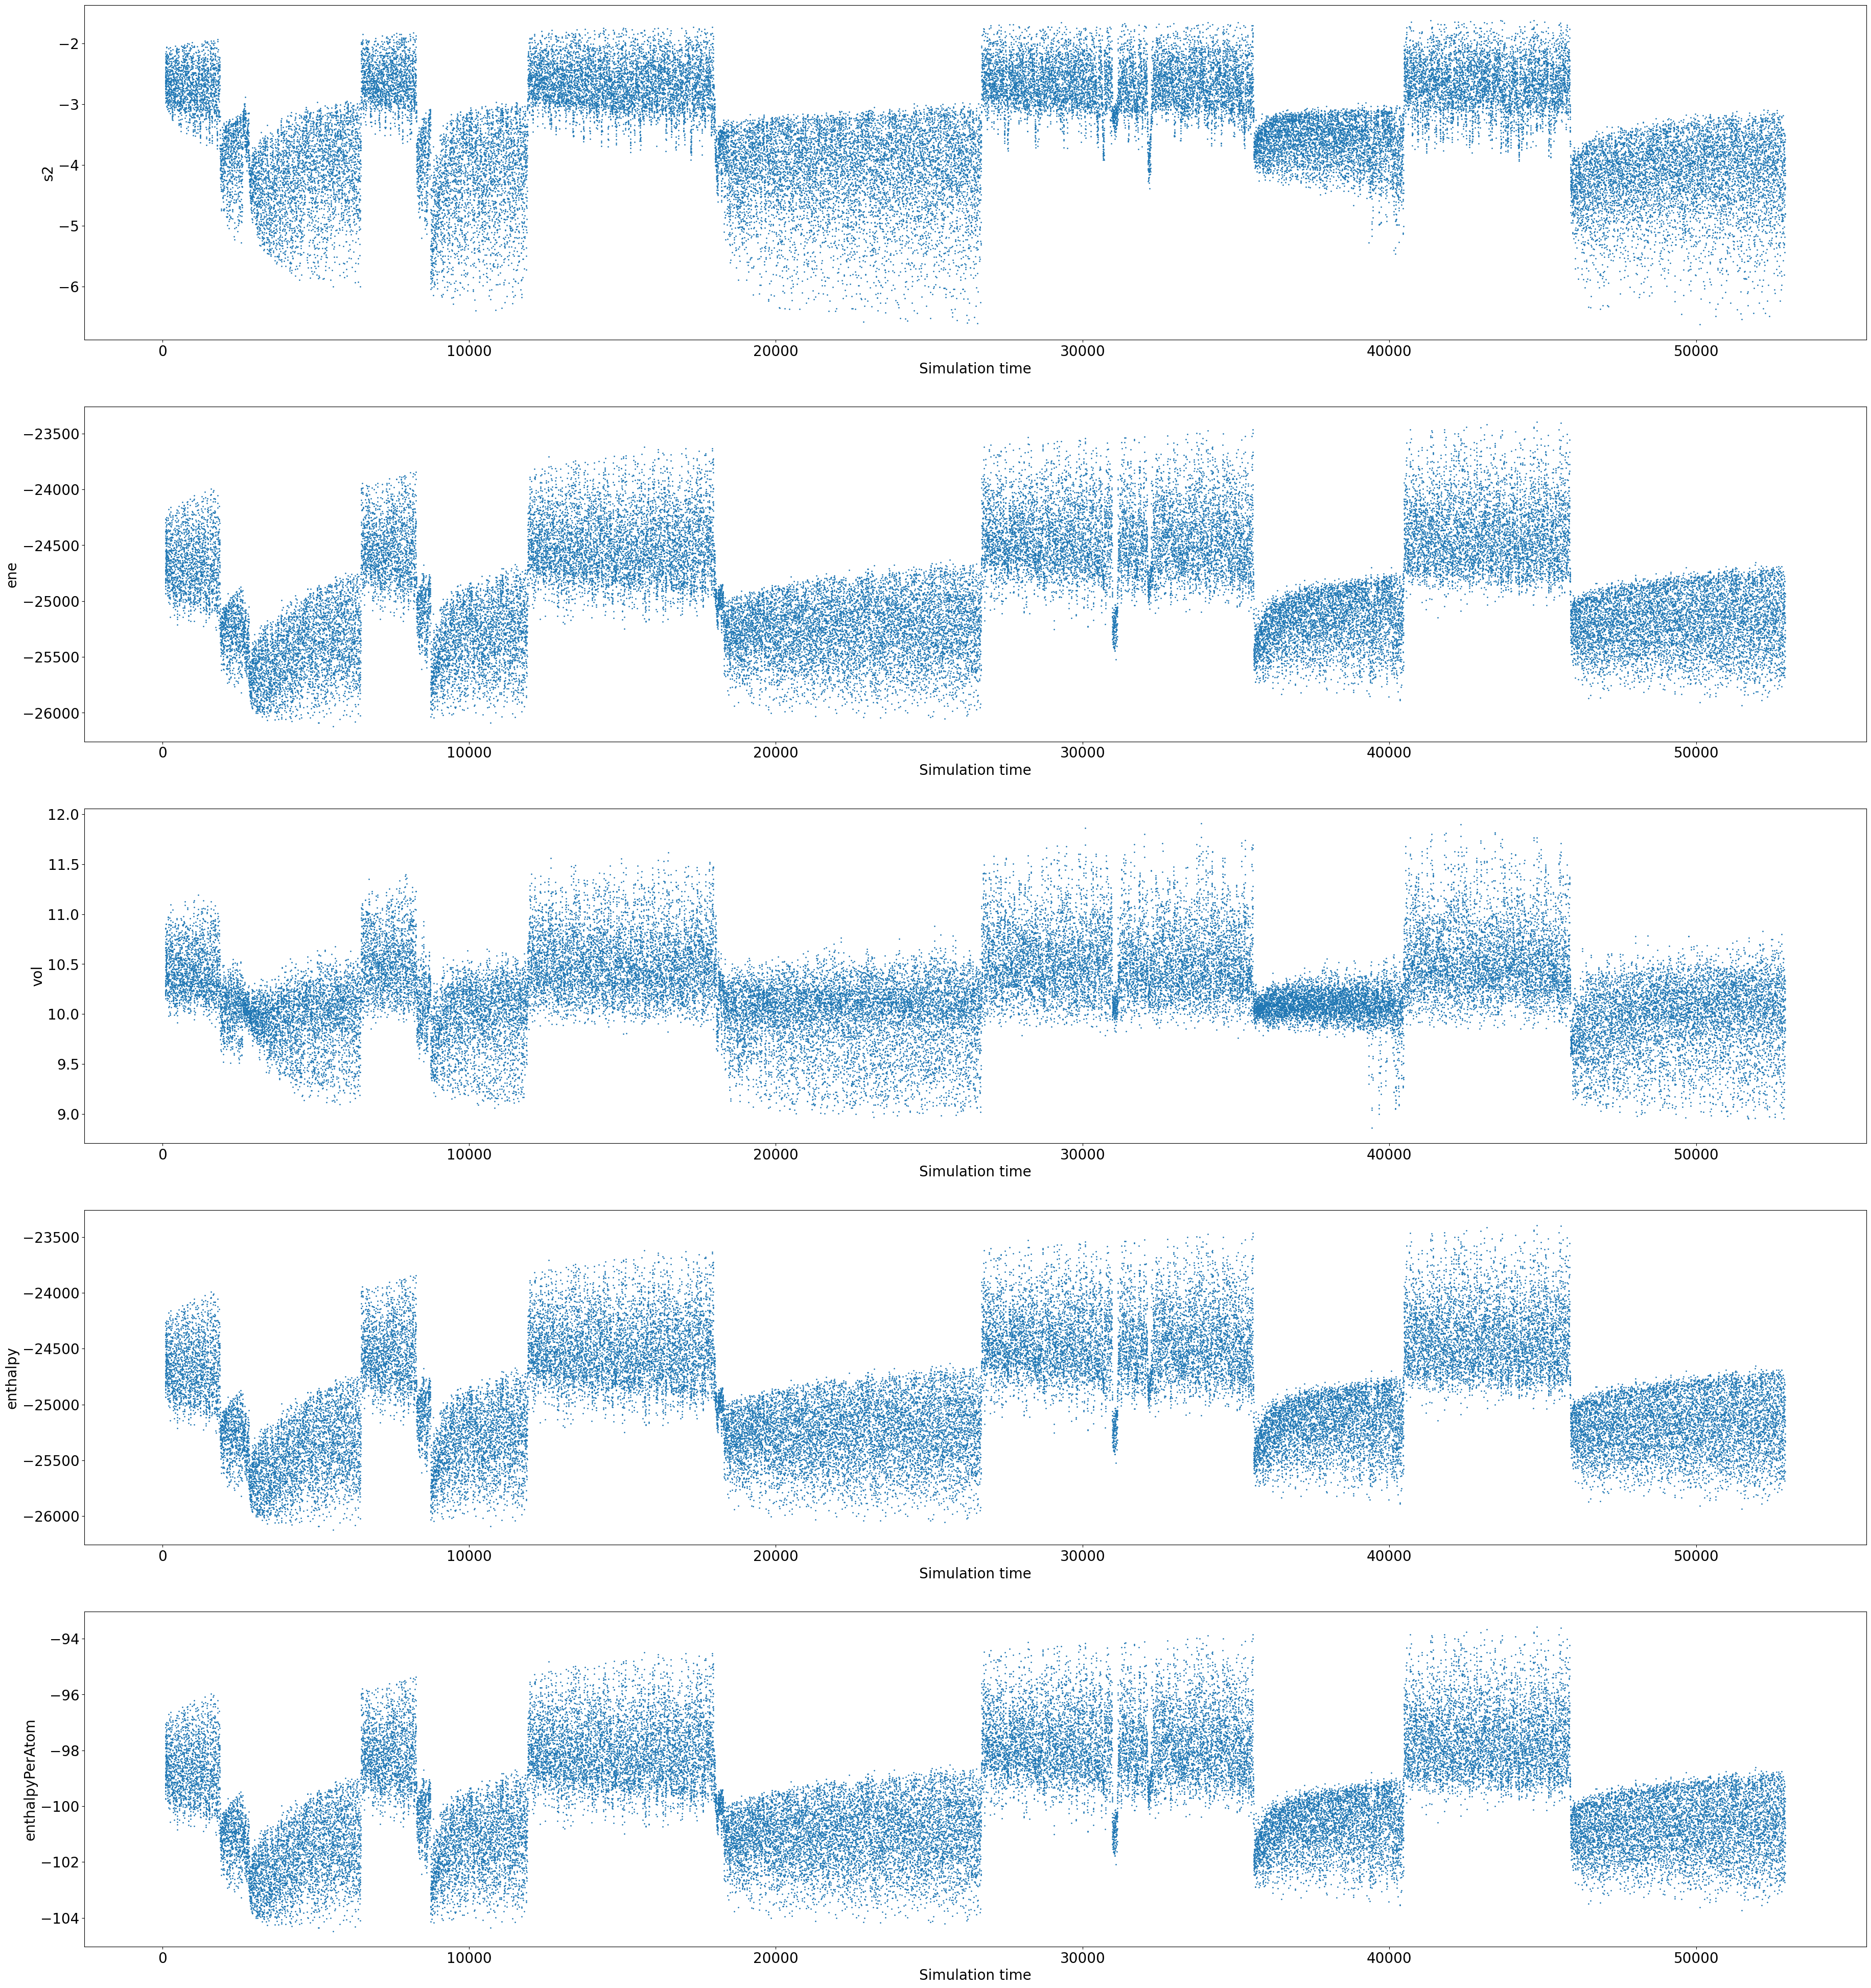

In [20]:
import plumed
from matplotlib import pyplot as plt
from matplotlib import rc

# visualize CV file
data=plumed.read_as_pandas("colvars/COLVAR")

labels = ['s2', 'ene', 'vol', 'enthalpy', 'enthalpyPerAtom'] #, 'metad.bias', 'metad.rbias', 'metad.rct' ]
fontsize = 20
font = {'family': 'sans', 'weight': 'normal', 'size': fontsize}
rc('font', **font)

fig = plt.figure(figsize=(45, 80))
for n,label in enumerate(labels):
    ax = fig.add_subplot(8,1,n+1)
    # plot phi during simulation (first 200k points)
    plt.plot(data["time"][:],data[label][:],'o', ms=1)
    # x-y axis labels
    plt.xlabel("Simulation time")
    plt.ylabel(label)
 

plt.show()

